# Analysis of the hits energies based on the plots found in 2.3 p2

Here, we want to check the energetic distributions of hits in their energetic regions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csgraph
from typing import List
import glob
import os
from scipy.interpolate import griddata

# Set some default plot styles
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

def in_range(series, low, high):
    return (series >= low) & (series <= high)


def get_corr3d(fname):
    krmap = pd.read_hdf(fname, "/krmap")
    meta  = pd.read_hdf(fname, "/mapmeta")
    dtxy_map   = krmap.loc[:, list("zxy")].values
    factor_map = krmap.factor.values
    def corr(dt, x, y, method="nearest"):
        dtxy_data   = np.stack([dt, x, y], axis=1)
        factor_data = griddata(dtxy_map, factor_map, dtxy_data, method=method)
        return factor_data
    return corr

def get_iso_and_non_iso_hits(hits_df):
    all_non_iso = hits_df[~hits_df['is_isolated']]
    all_iso = hits_df[hits_df['is_isolated']]
    return all_non_iso, all_iso

def prepare_hits_in_and_out_Z(hits_df):
    
    all_non_iso, all_iso = get_iso_and_non_iso_hits(hits_df)

    z_ranges = all_non_iso.groupby('event')['Z'].agg(['min', 'max']).rename(columns={'min': 'Z_min', 'max': 'Z_max'})
    iso_with_z_range = all_iso.merge(z_ranges, on='event', how='left')
    iso_with_z_range.dropna(subset=['Z_min', 'Z_max'], inplace=True)

    # Create the mask for Z-cuts
    z_cut_mask = (iso_with_z_range['Z'] >= iso_with_z_range['Z_min']) & (iso_with_z_range['Z'] <= iso_with_z_range['Z_max'])
    # --- Generate Report 2: Isolated Hits IN Z-Range ---
    iso_in_z_range = iso_with_z_range[z_cut_mask]
    # --- Generate Report 3: Isolated Hits OUT of Z-Range ---
    iso_out_of_z_range = iso_with_z_range[~z_cut_mask]
    return iso_in_z_range, iso_out_of_z_range

In [2]:
H5_FILE_PATH = "/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/15589/sophronia/clean_df/run_15589_ldc1_clean.h5"
H5_FILE_PATH2 = "/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/15590/sophronia/clean_df/run_15590_ldc2_clean.h5"
H5_FILE_PATH3 = "/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/15591/sophronia/clean_df/run_15591_ldc3_clean.h5"

file_list = [H5_FILE_PATH, H5_FILE_PATH2, H5_FILE_PATH3]
#file_list = glob.glob(H5_FILE_PATH, H5_FILE_PATH2, H5_FILE_PATH3)

map_file_path = f"/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/combined_15546_15557.map3d"
corr3d = get_corr3d(map_file_path)

if not file_list:
    raise FileNotFoundError(f"No files found matching {H5_FILE_PATH}")

print(f"Found {len(file_list)} files:")
for f in file_list:
    print(" -", os.path.basename(f))

hits_dfs = []
for f in file_list:
    print(f"\nLoading dataset from {f}...")
    df = pd.read_hdf(f, key='RECO/Events')
    hits_dfs.append(df)
    print(f"  Loaded {len(df)} hits from {df['event'].nunique()} events.")

# Concatenate all hits
hits_df = pd.concat(hits_dfs, ignore_index=True)
print(f"\nFull dataset loaded successfully with {len(hits_df)} hits from {hits_df['event'].nunique()} events.")
#hits_df["R"]  = np.sqrt( hits_df.X**2 + hits_df.Y**2 )
# --- Aggregate event-level info ---
event_agg = hits_df.groupby('event').agg(
#    Rmax=('R', 'max'),
    Zmax=('Z', 'max'),
    Zmin=('Z', 'min')
).reset_index()

filtered_events = event_agg[
#    in_range(event_agg.Rmax, 0, 450) &
    in_range(event_agg.Zmin, 20, 1184.185) &
    in_range(event_agg.Zmax, 20, 1184.185)
]

print(f"Events passing fiducial cut: {len(filtered_events)} / {len(event_agg)}")

# --- Keep only surviving events in hits_df ---
hits_df = hits_df[hits_df['event'].isin(filtered_events['event'])].copy()
corr_factors = corr3d(hits_df.Z, hits_df.X, hits_df.Y)
hits_df['E_corr'] = hits_df.E * corr_factors

print("\n--- After Fiducial Cut ---")
print(f"Number of events for analysis: {hits_df['event'].nunique()}")
print(f"Number of hits for analysis: {len(hits_df)}")


# Set the fraction of events you want to keep
fraction_to_keep = 1
num_events_to_keep = int(len(filtered_events) * fraction_to_keep)

print(f"Randomly selecting {num_events_to_keep} events ({fraction_to_keep:.0%}) for analysis...")

# Randomly choose the event IDs to keep. 'replace=False' ensures each event is chosen only once.
np.random.seed(42) # Using a seed for reproducibility
events_to_keep = np.random.choice(filtered_events['event'], size=num_events_to_keep, replace=False)

# Filter the main DataFrame to keep only the hits from the selected events
hits_df = hits_df[hits_df['event'].isin(events_to_keep)].copy()


print("\n--- Data Reduction Complete ---")
print(f"Number of events for analysis: {hits_df['event'].nunique()}")
print(f"Number of hits for analysis: {len(hits_df)}")




Found 3 files:
 - run_15589_ldc1_clean.h5
 - run_15590_ldc2_clean.h5
 - run_15591_ldc3_clean.h5

Loading dataset from /lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/15589/sophronia/clean_df/run_15589_ldc1_clean.h5...
  Loaded 35991724 hits from 49651 events.

Loading dataset from /lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/15590/sophronia/clean_df/run_15590_ldc2_clean.h5...
  Loaded 36252745 hits from 49277 events.

Loading dataset from /lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/15591/sophronia/clean_df/run_15591_ldc3_clean.h5...
  Loaded 36139076 hits from 49021 events.

Full dataset loaded successfully with 108383545 hits from 147949 events.
Events passing fiducial cut: 134705 / 147949

--- After Fiducial Cut ---
Number of events for analysis: 134705
Number of hits for analysis: 95633687
Randomly selecting 134705 events (100%) for analysis...

--- Data Reduction Complete ---
Number of events for analysis: 134705
Number of h

So, knowing that in the group of hits that are inside Z range, there is a big density of points in some energy ranges, in the three coordinates, something that is not happenning in the group of hits outside Z range, then we would like to see both spectras and compare them, while looking for the energeti region where the majority of the "good" htis are located

In [3]:
def analyze_density_comparison(df_in_z, df_out_z, variable='E', source_name='Thallium'):
    """
    Analyzes and plots the distribution of a variable (Energy or Charge)
    for IN and OUT of Z-Range hits to compare their concentration.
    Includes data cleaning for log scales.
    """
    # --- 1. Data Cleaning ---
    # Filter both DataFrames to keep only strictly positive values for the chosen variable.
    # We use .copy() to ensure we don't modify the original DataFrames outside this function.
    data_in = df_in_z[df_in_z[variable] > 0].copy()
    data_out = df_out_z[df_out_z[variable] > 0].copy()

    if data_in.empty or data_out.empty:
        print(f"Skipping density analysis for '{variable}': No positive values found in one or both datasets after cleaning.")
        return

    # --- 2. Define the Region of Interest (ROI) from the IN-Z-Range data ---
    # Find the 5th and 95th percentiles to get the central 90% of the data
    roi_min = data_in[variable].quantile(0.05)
    roi_max = data_in[variable].quantile(0.95)

    #roi_min = data_in[variable].quantile(0.025)
    #roi_max = data_in[variable].quantile(0.975)

    # --- 3. Calculate the percentage of OUT-of-Z-Range hits within the ROI ---
    out_in_roi = data_out[(data_out[variable] >= roi_min) & (data_out[variable] <= roi_max)]
    percentage = (len(out_in_roi) / len(data_out)) * 100

    # --- 4. Create the comparison plot ---
    plt.figure(figsize=(12, 7))
    
    # Determine global min and max positive values for binning
    global_min = min(data_in[variable].min(), data_out[variable].min())
    global_max = max(data_in[variable].max(), data_out[variable].max())

    # Define shared log-spaced bins
    bins = np.logspace(np.log10(global_min), np.log10(global_max), 150)

    # Plot normalized histograms (densities) for shape comparison
    # Note: 'density=True' normalizes the area under the histogram to 1.
    plt.hist(data_in[variable], bins=bins, density=True, histtype='step', linewidth=2, color='blue',
             label=f'IN Z-Range (Total Positive Hits: {len(data_in):,})')
    plt.hist(data_out[variable], bins=bins, density=True, histtype='step', linewidth=2, color='orange',
             label=f'OUT of Z-Range (Total Positive Hits: {len(data_out):,})')

    # Highlight the 90% ROI from the IN-Z-Range data
    plt.axvspan(roi_min, roi_max, color='red', alpha=0.15, label='Central 90% Region of IN-Range')

    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which='both', linestyle=':', alpha=0.7)
    
    units = 'pes'
    var_name = 'Energy' if variable == 'E' else 'Charge'
    plt.xlabel(f'Individual Hit {var_name} ({units})')
    plt.ylabel('Normalized Probability Density')
    plt.title(f'Comparison of Hit {var_name} Distribution ({source_name})')
    
    # Add a text box with the analysis result
    result_text = (f"--- Analysis Results ---\n"
                   f"Central 90% of IN-Range hits:\n"
                   f"[{roi_min:.2e}, {roi_max:.2e}] {units}\n\n"
                   f"Percentage of OUT-of-Range hits\n"
                   f"falling within this region:\n"
                   f"--> {percentage:.1f}%")
    
    plt.text(0.02, 0.98, result_text, transform=plt.gca().transAxes, fontsize=11, fontfamily='monospace',
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    plt.legend(loc='upper right')
    plt.show()

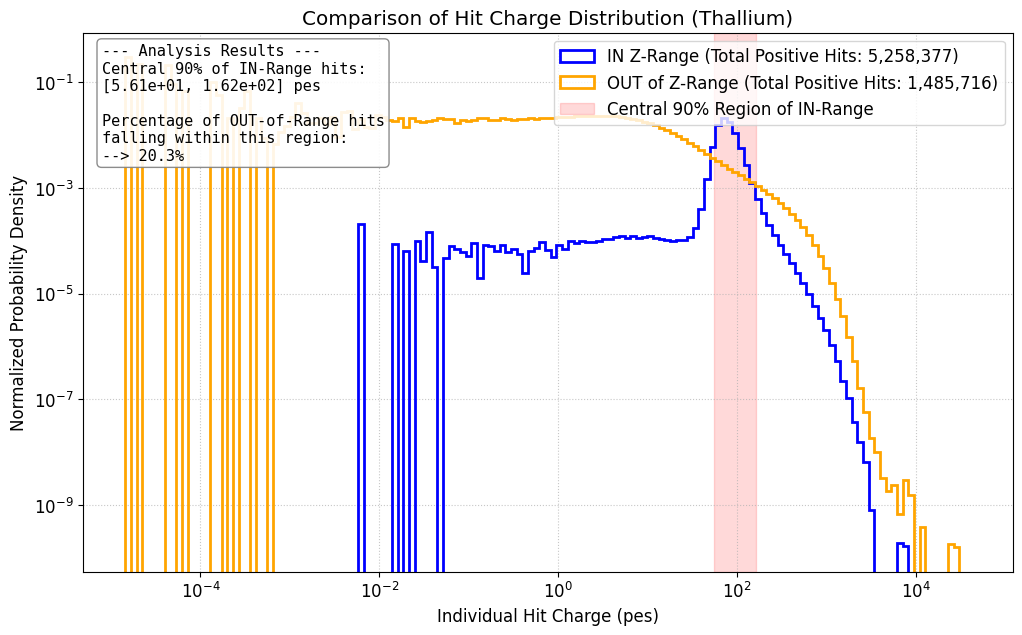

In [83]:
# 1. Compare the ENERGY distributions
iso_in_z_range, iso_out_of_z_range = prepare_hits_in_and_out_Z(hits_df)
analyze_density_comparison(
    df_in_z=iso_in_z_range,
    df_out_z=iso_out_of_z_range,
    variable='E_corr', # Tell the function to use the 'E' column
    source_name='Thallium'
)

So with this, we can do the background substraction with this fun and interesting function:

In [4]:
def plot_background_subtracted_spectrum(df_in, df_out, variable='E', source_name='Thallium'):
    """
    Performs a scaled background subtraction of energy or charge spectra and plots the result.

    Args:
        df_in (pd.DataFrame): The signal + background dataframe (e.g., IN Z-Range).
        df_out (pd.DataFrame): The background-only dataframe (e.g., OUT of Z-Range).
        variable (str): The column to analyze, either 'E' for Energy or 'Q' for Charge.
    """
    print(f"\n--- Performing Background Subtraction for: {variable} Spectrum ---")

    # Clean the data to ensure only positive values are used for log binning
    data_in = df_in[df_in[variable] > 0]
    data_out = df_out[df_out[variable] > 0]

    if data_in.empty or data_out.empty:
        print("Cannot perform subtraction: one or both dataframes have no positive values.")
        return

    # Create a common set of bins for both histograms
    global_min = min(data_in[variable].min(), data_out[variable].min())
    global_max = max(data_in[variable].max(), data_out[variable].max())
    bins = np.logspace(np.log10(global_min), np.log10(global_max), 100)

    # Get the histogram counts for both datasets
    counts_in, _ = np.histogram(data_in[variable], bins=bins)
    counts_out, _ = np.histogram(data_out[variable], bins=bins)

    # --- Scaling and Subtraction ---
    # We scale the background by the ratio of total hits.
    # Note: A more precise method could scale by the geometric volume of the two regions.
    scaling_factor = len(data_in) / len(data_out)
    counts_subtracted = counts_in - (scaling_factor * counts_out)
    
    # --- Error Propagation ---
    # Error on subtracted bin = sqrt(err_in^2 + (k * err_out)^2)
    # For Poisson counts, err = sqrt(N). So, err^2 = N.
    error_subtracted = np.sqrt(counts_in + (scaling_factor**2 * counts_out))

    # Get the center of the bins for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # --- Plotting ---
    plt.figure(figsize=(12, 7))
    plt.errorbar(bin_centers, counts_subtracted, yerr=error_subtracted, fmt='o', markersize=4, 
                 capsize=3, label='Subtracted Data (Signal)')
    
    # Add a line at y=0 for reference
    plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Level')
    
    # We fill the areas where the subtracted spectrum is positive
    positive_mask = counts_subtracted > 0
    plt.fill_between(bin_centers, counts_subtracted, 0, where=positive_mask, 
                     color='orange', alpha=0.3, label='Positive Signal Region')


    plt.xscale('log')
    # The y-axis can be negative, so we use a linear scale here
    plt.yscale('linear') 
    
    plt.grid(True, which='both', linestyle=':')
    var_name = 'Energy' if variable == 'E' else 'Charge'
    plt.xlabel(f'Individual Hit {var_name} (pes)')
    plt.xlim(10e-2, global_max*1.2)
    plt.ylabel('Signal Counts (Background Subtracted)')
    plt.title(f'Pure Signal {var_name} Spectrum ({source_name})')
    plt.legend()
    plt.show()


--- Performing Background Subtraction for: E_corr Spectrum ---


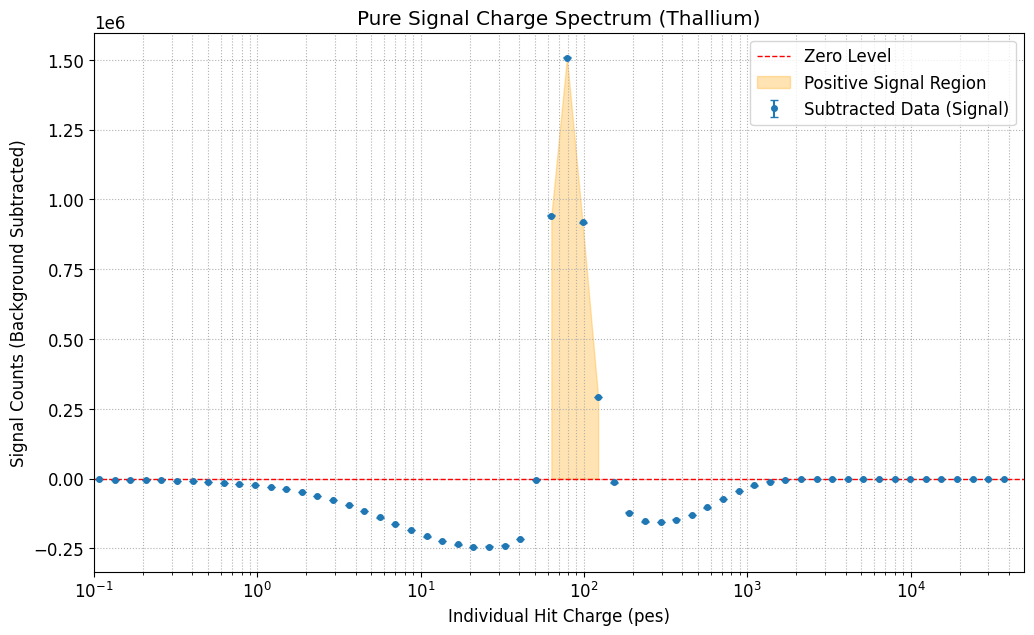

In [84]:
plot_background_subtracted_spectrum(iso_in_z_range, iso_out_of_z_range, variable='E_corr')

## This is for the global events, now lets check this same plots, but separating by event energy


In [7]:
#lets calculate the total energy of the event, by removing the out Z hits and redistributing internal energies

iso_in_z_range, iso_out_of_z_range = prepare_hits_in_and_out_Z(hits_df)
all_non_iso, all_iso = get_iso_and_non_iso_hits(hits_df)

energy_to_redistribute = iso_in_z_range.groupby('event')['E_corr'].sum().rename('E_iso_to_add')
all_non_iso_m = all_non_iso.merge(energy_to_redistribute, on='event', how='left')
all_non_iso_m['E_iso_to_add'].fillna(0, inplace=True)
non_iso_energy_sum = all_non_iso.groupby('event')['E_corr'].transform('sum').replace(0, 1)
all_non_iso_m['E_final'] = all_non_iso_m['E_corr'] + \
                                     (all_non_iso_m['E_corr'] / non_iso_energy_sum) * all_non_iso_m['E_iso_to_add']



event_agg = all_non_iso_m.groupby('event').agg(E_final=('E_final', 'sum'))

#get the dst
dst_dfs = []
for f in file_list:
    print(f"\nLoading dataset from {f}...")
    df = pd.read_hdf(f, key='DST/Events')
    dst_dfs.append(df)

dst_df = pd.concat(dst_dfs, ignore_index=True)
dst_df = dst_df.merge(event_agg, on='event', how='left')

#now lets keep only events whhose E_final is in the DE peak value range between
events_in_DE_peak = dst_df[(dst_df['E_final'] >= 3.23e5) & (dst_df['E_final'] <= 3.37e5)][['event']]
#similarly for event in the tl peak
events_in_Tl_peak = dst_df[(dst_df['E_final'] >= 5.34e5) & (dst_df['E_final'] <= 5.54e5)][['event']]

events_in_3rd_peak = dst_df[(dst_df['E_final'] >= 1.71e5) & (dst_df['E_final'] <= 1.84e5)][['event']]

#the im going to tak my two original dfs all_non_iso and all_iso and create two subgroups containing only the events of the two previous selected dfs
hits_df_DE = hits_df[hits_df['event'].isin(events_in_DE_peak['event'])]
hits_df_Tl = hits_df[hits_df['event'].isin(events_in_Tl_peak['event'])]
hits_df_3rd = hits_df[hits_df['event'].isin(events_in_3rd_peak['event'])]   







Loading dataset from /lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/15589/sophronia/clean_df/run_15589_ldc1_clean.h5...

Loading dataset from /lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/15590/sophronia/clean_df/run_15590_ldc2_clean.h5...

Loading dataset from /lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/15591/sophronia/clean_df/run_15591_ldc3_clean.h5...


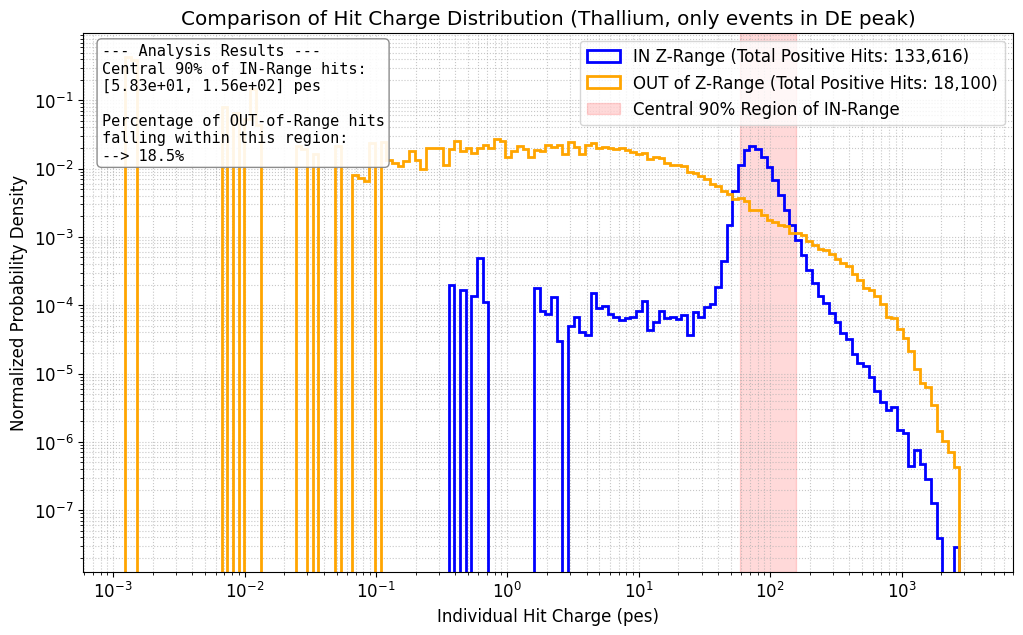

In [86]:
#first for those in the DE peak
iso_in_z_range, iso_out_of_z_range = prepare_hits_in_and_out_Z(hits_df_DE)

analyze_density_comparison(
    df_in_z=iso_in_z_range,
    df_out_z=iso_out_of_z_range,
    variable='E_corr', # Tell the function to use the 'E' column
    source_name='Thallium, only events in DE peak'
)

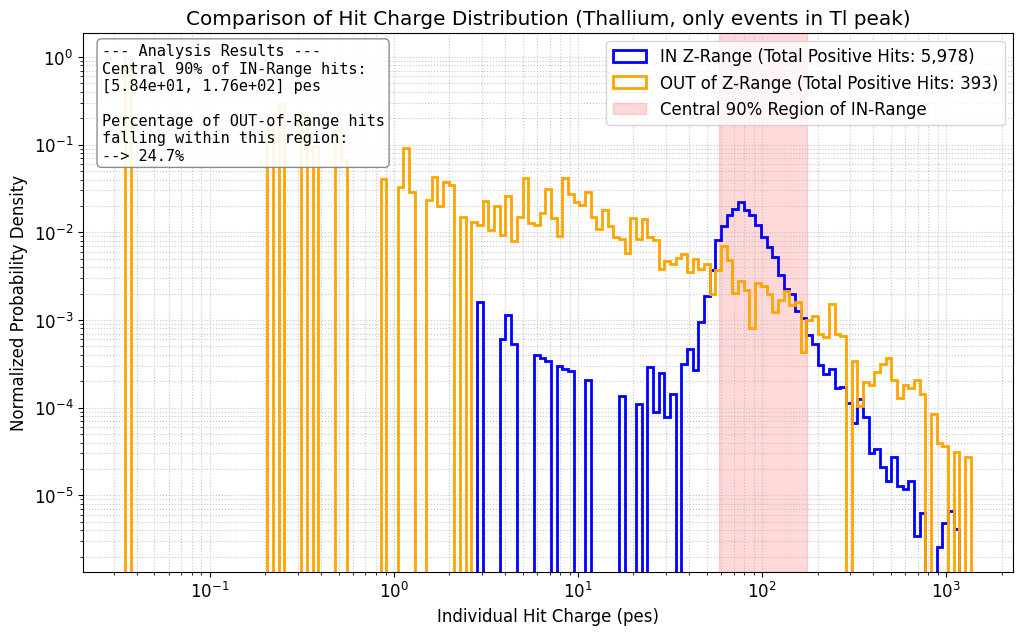

In [87]:
# now for the Tl peak
iso_in_z_range, iso_out_of_z_range = prepare_hits_in_and_out_Z(hits_df_Tl)
analyze_density_comparison(
    df_in_z=iso_in_z_range,
    df_out_z=iso_out_of_z_range,
    variable='E_corr', # Tell the function to use the 'E' column
    source_name='Thallium, only events in Tl peak'
)

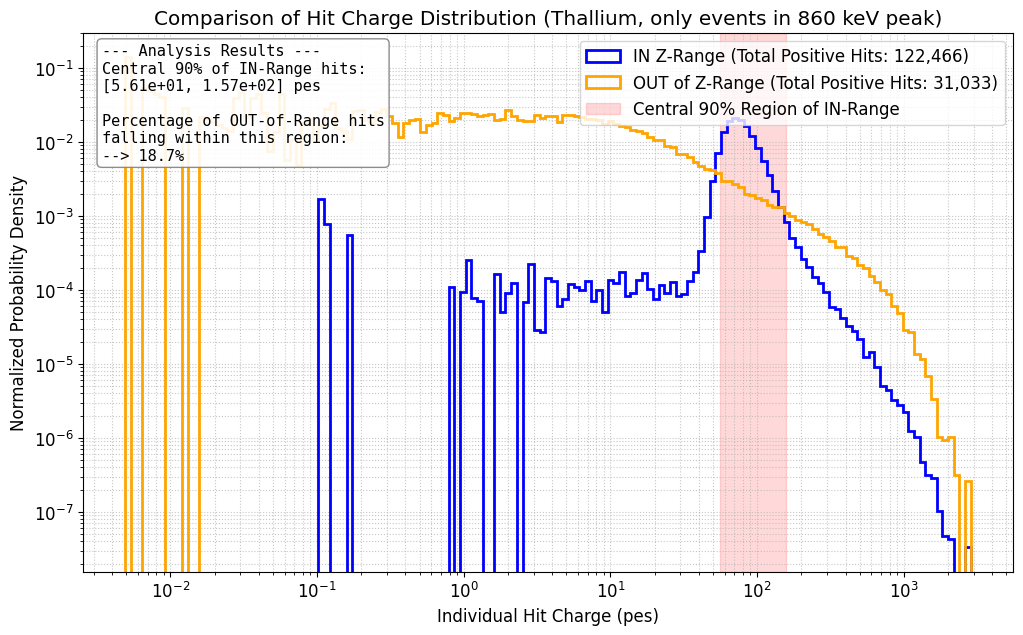

In [88]:
iso_in_z_range, iso_out_of_z_range = prepare_hits_in_and_out_Z(hits_df_3rd)
analyze_density_comparison(
    df_in_z=iso_in_z_range,
    df_out_z=iso_out_of_z_range,
    variable='E_corr', # Tell the function to use the 'E' column
    source_name='Thallium, only events in 860 keV peak'
)

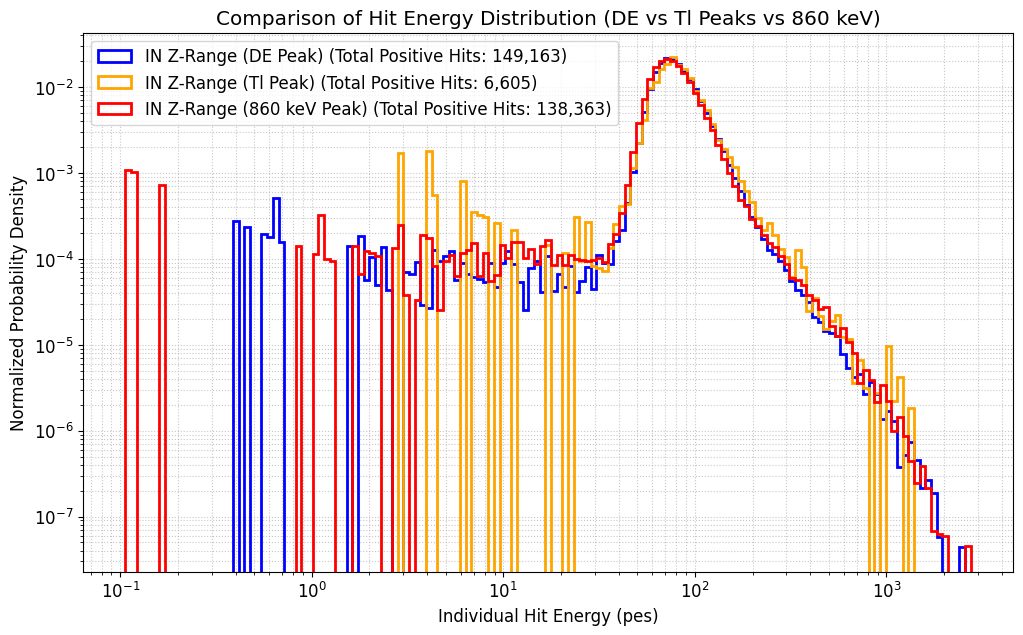

In [8]:
iso_in_z_range_DE, iso_out_of_z_range_DE = prepare_hits_in_and_out_Z(hits_df_DE)
iso_in_z_range_Tl, iso_out_of_z_range_Tl = prepare_hits_in_and_out_Z(hits_df_Tl)
iso_in_z_range_3rd, iso_out_of_z_range_3rd = prepare_hits_in_and_out_Z(hits_df_3rd)

#now lets plot a simple comparison of the energy spectra of the hits inside Z range for both DE and Tl peaks


plt.figure(figsize=(12, 7))
# Determine global min and max positive values for binning
global_min = min(
    iso_in_z_range_DE['E_corr'][iso_in_z_range_DE['E_corr'] > 0].min(),
    iso_in_z_range_Tl['E_corr'][iso_in_z_range_Tl['E_corr'] > 0].min(),
    iso_in_z_range_3rd['E_corr'][iso_in_z_range_3rd['E_corr'] > 0].min()
)
global_max = max(
    iso_in_z_range_DE['E_corr'][iso_in_z_range_DE['E_corr'] > 0].max(),
    iso_in_z_range_Tl['E_corr'][iso_in_z_range_Tl['E_corr'] > 0].max(),
    iso_in_z_range_3rd['E_corr'][iso_in_z_range_3rd['E_corr'] > 0].max()
)
# Define shared log-spaced bins
bins = np.logspace(np.log10(global_min), np.log10(global_max), 150)
# Plot normalized histograms (densities) for shape comparison
# Note: 'density=True' normalizes the area under the histogram to 1.
plt.hist(iso_in_z_range_DE['E_corr'], bins=bins, density=True, histtype='step', linewidth=2, color='blue',
         label=f'IN Z-Range (DE Peak) (Total Positive Hits: {len(iso_in_z_range_DE):,})')
plt.hist(iso_in_z_range_Tl['E_corr'], bins=bins, density=True, histtype='step', linewidth=2, color='orange',
         label=f'IN Z-Range (Tl Peak) (Total Positive Hits: {len(iso_in_z_range_Tl):,})')
plt.hist(iso_in_z_range_3rd['E_corr'], bins=bins, density=True, histtype='step', linewidth=2, color='red',
         label=f'IN Z-Range (860 keV Peak) (Total Positive Hits: {len(iso_in_z_range_3rd):,})')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', linestyle=':', alpha=0.7)
units = 'pes'
var_name = 'Energy'
plt.xlabel(f'Individual Hit {var_name} ({units})')
plt.ylabel('Normalized Probability Density')
plt.title(f'Comparison of Hit {var_name} Distribution (DE vs Tl Peaks vs 860 keV)')
plt.legend(loc='upper left')
plt.show()

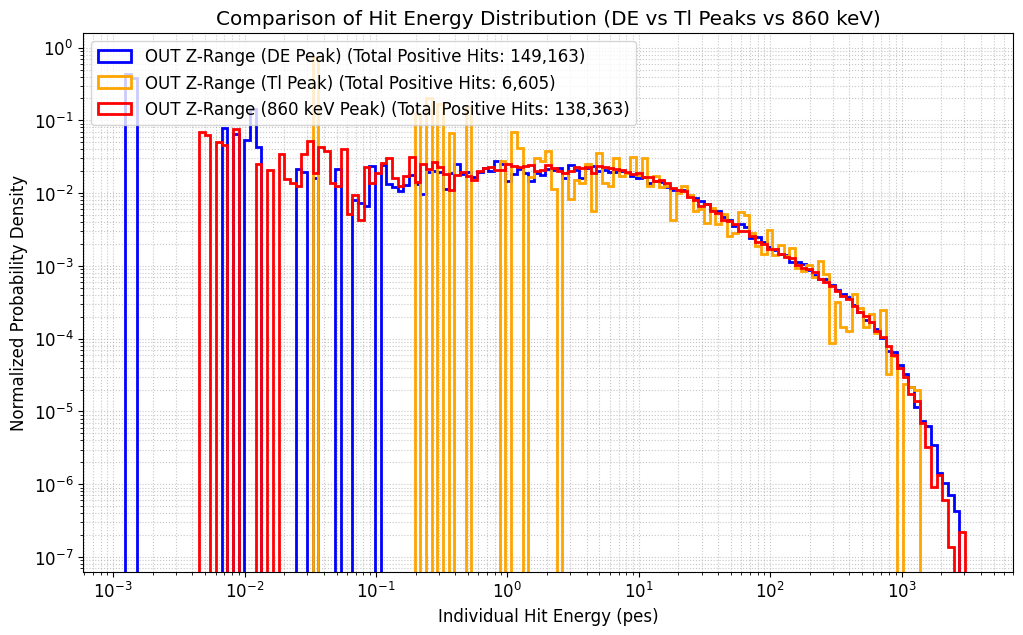

In [9]:
plt.figure(figsize=(12, 7))
# Determine global min and max positive values for binning
global_min = min(
    iso_out_of_z_range_DE['E_corr'][iso_out_of_z_range_DE['E_corr'] > 0].min(),
    iso_out_of_z_range_Tl['E_corr'][iso_out_of_z_range_Tl['E_corr'] > 0].min(),
    iso_out_of_z_range_3rd['E_corr'][iso_out_of_z_range_3rd['E_corr'] > 0].min()
)
global_max = max(
    iso_out_of_z_range_DE['E_corr'][iso_out_of_z_range_DE['E_corr'] > 0].max(),
    iso_out_of_z_range_Tl['E_corr'][iso_out_of_z_range_Tl['E_corr'] > 0].max(),
    iso_out_of_z_range_3rd['E_corr'][iso_out_of_z_range_3rd['E_corr'] > 0].max()
)
# Define shared log-spaced bins
bins = np.logspace(np.log10(global_min), np.log10(global_max), 150)
# Plot normalized histograms (densities) for shape comparison
# Note: 'density=True' normalizes the area under the histogram to 1.
plt.hist(iso_out_of_z_range_DE['E_corr'], bins=bins, density=True, histtype='step', linewidth=2, color='blue',
         label=f'OUT Z-Range (DE Peak) (Total Positive Hits: {len(iso_in_z_range_DE):,})')
plt.hist(iso_out_of_z_range_Tl['E_corr'], bins=bins, density=True, histtype='step', linewidth=2, color='orange',
         label=f'OUT Z-Range (Tl Peak) (Total Positive Hits: {len(iso_in_z_range_Tl):,})')
plt.hist(iso_out_of_z_range_3rd['E_corr'], bins=bins, density=True, histtype='step', linewidth=2, color='red',
         label=f'OUT Z-Range (860 keV Peak) (Total Positive Hits: {len(iso_in_z_range_3rd):,})')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', linestyle=':', alpha=0.7)
units = 'pes'
var_name = 'Energy'
plt.xlabel(f'Individual Hit {var_name} ({units})')
plt.ylabel('Normalized Probability Density')
plt.title(f'Comparison of Hit {var_name} Distribution (DE vs Tl Peaks vs 860 keV)')
plt.legend(loc='upper left')
plt.show()